<a href="https://colab.research.google.com/github/ShesterG/Stance-Detection-Ghana-2020-Elections/blob/main/Notebooks/SGD_3Classes_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stochastic Gradient Descent Model for Twitter Stance (3 Classes) Analysis

# Imports and Constants

In [1]:
!git clone https://github.com/ShesterG/Stance-Detection-Ghana-2020-Elections.git

%cd Stance-Detection-Ghana-2020-Elections/

Cloning into 'Stance-Detection-Ghana-2020-Elections'...
remote: Enumerating objects: 70, done.
remote: Counting objects: 100% (70/70), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 70 (delta 27), reused 15 (delta 7), pack-reused 0
Unpacking objects: 100% (70/70), done.
Checking out files: 100% (20/20), done.
/content/Stance-Detection-Ghana-2020-Elections


In [2]:
import pandas as pd
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, plot_confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.preprocessing import LabelBinarizer
#import evaluation_functions
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfTransformer 
from imblearn.over_sampling import SMOTE
import ast



from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict

from sklearn.model_selection import StratifiedKFold


from sklearn.metrics import make_scorer

In [3]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [4]:
DATA_FILE_PATH = '/content/Stance-Detection-Ghana-2020-Elections/Dataset/'
CLEAN_DATA_FILE_NAME = '01EDA_All_Model_Tweets_Ghana_2020_Elections_L.csv'
TOKENIZED_DATA_FILE_NAME = '02TPP_All_Model_Tweets_Ghana_2020_Elections_L.csv'
pd.set_option('display.max_colwidth', None)
RANDOM_STATE = 42

# Load Data

In [5]:
df = pd.read_csv(DATA_FILE_PATH + TOKENIZED_DATA_FILE_NAME)

In [6]:
df.head()

,ID,Tweet,Candidate,Stance,Preproc_Tweet,Tokens
0,2,"@NAkufoAddo H. E Nana please follow up on this FAKE NEWS, LIES and sue BBC for peddling false information. Hold alÃ¢â¬Â¦ https://t.co/SdwnMsxeUV",Nana,0.0,nana h e nana please follow up on this fake news lies and sue bbc for peddling false information hold al,"['nana', 'h', 'e', 'nana', 'pleas', 'follow', 'up', 'on', 'thi', 'fake', 'news', 'lie', 'and', 'sue', 'bbc', 'for', 'peddl', 'fals', 'inform', 'hold', 'al']"
1,6,"@ChipsJhay @TruthFreema @AOuattara_PRCI @NAkufoAddo No, you haven't. He's using his freedom of speech as it is. He's covered.",Nana,0.0,nana no you haven't he's using his freedom of speech as it is he's covered,"['nana', 'no', 'you', ""haven't"", ""he'"", 'use', 'hi', 'freedom', 'of', 'speech', 'as', 'it', 'is', ""he'"", 'cover']"
2,7,@IssahGerard @HEgyiri @NAkufoAddo Please who is this and how is he your in law??,Nana,0.0,nana please who is this and how is he your in law,"['nana', 'pleas', 'who', 'is', 'thi', 'and', 'how', 'is', 'he', 'your', 'in', 'law']"
3,17,@Kwame34580189 @bukolasaraki @NAkufoAddo Whatever.... Thought you had something there....,Nana,0.0,nana whatever thought you had something there,"['nana', 'whatev', 'thought', 'you', 'had', 'someth', 'there']"
4,18,@NAkufoAddo Remember that the good people of Gh have spoken therefore Soo be it,Nana,0.0,nana remember that the good people of gh have spoken therefore soo be it,"['nana', 'rememb', 'that', 'the', 'good', 'peopl', 'of', 'gh', 'have', 'spoken', 'therefor', 'soo', 'be', 'it']"


In [7]:
#df = df[df.Stance != 0]

In [8]:
df.Tokens = df.Tokens.map(ast.literal_eval)

In [9]:
data = df[['Tokens', 'Stance']]

In [10]:
df.value_counts(["Candidate", "Stance"])

Candidate  Stance
Nana        0.0      803
John       -1.0      515
            1.0      515
Nana       -1.0      515
            1.0      515
John        0.0      227
dtype: int64

In [11]:
data.Stance.value_counts()

 0.0    1030
 1.0    1030
-1.0    1030
Name: Stance, dtype: int64

In [12]:
data.head()

,Tokens,Stance
0,"[nana, h, e, nana, pleas, follow, up, on, thi, fake, news, lie, and, sue, bbc, for, peddl, fals, inform, hold, al]",0.0
1,"[nana, no, you, haven't, he', use, hi, freedom, of, speech, as, it, is, he', cover]",0.0
2,"[nana, pleas, who, is, thi, and, how, is, he, your, in, law]",0.0
3,"[nana, whatev, thought, you, had, someth, there]",0.0
4,"[nana, rememb, that, the, good, peopl, of, gh, have, spoken, therefor, soo, be, it]",0.0


# Split Data

In [13]:
X = data['Tokens']
y = data['Stance']

# Encode Labels

In [14]:
le = LabelEncoder()

In [15]:
y_enc = le.fit_transform(y)

# Evaluate Adjustments to Minimum Document Frequency

In [16]:
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
class LemmaTokenizer:
    def __init__(self):
         self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in doc]

In [17]:
class stop_word_remover:
    def __init__(self):
         self.stop_words = frozenset(['the', 'to', 'at', 'rt', 'for', 'a', 
                                      'in', 'is', 'of', 'and', 'on', 'i', 
                                      'you', 'an', 'with', 'it', 'this'])
    def __call__(self, doc):
        return [t for t in doc if t not in self.stop_words]

In [18]:
def passthrough(doc):
    """passthrough function for use in the pipeline because the text is already tokenized"""
    return doc

In [19]:
def train_and_eval_model(min_df, ngram_range):
    """
    Train and Evaluate and Bag of Words Representation with a Naive Bayes
    classifier with a specified minimum document frequency.
    """
    
    pipeline = Pipeline([
                        ('bow',CountVectorizer(min_df=min_df,
                                               ngram_range=ngram_range,
                                               max_features=10000,
                                               analyzer='word',
                                               preprocessor=stop_word_remover(),
                                               tokenizer=LemmaTokenizer(), 
                                               lowercase=False)),  
                        ('tfidf', TfidfTransformer()),
                        ('smote', SMOTE(random_state=RANDOM_STATE, n_jobs=-1)),
                        ('classifier', SGDClassifier(random_state=RANDOM_STATE))])
    
   

    scoring = {'accuracy' : make_scorer(accuracy_score),
               'f1_score' : make_scorer(f1_score, average = 'micro'), 
               'precision' : make_scorer(precision_score, average = 'micro'),
               'recall' : make_scorer(recall_score, average = 'micro') 
              }
    
    scores = cross_validate(pipeline, X, y_enc, cv=10, scoring=scoring)
    sorted(scores.keys())

    y_pred = cross_val_predict(pipeline, X, y_enc, cv=10)

    
    print(f'MINIMUM DOCUMENT FREQUENCY = {min_df}')
    print('')
    
    conf_matrix = confusion_matrix(y_true=y_enc, y_pred=y_pred)

    classi_report = classification_report(y_true=y_enc, y_pred=y_pred, digits=4, target_names=['Negative','Neutral','Postive'])
    print(classi_report)

    
    a = scores['test_accuracy'].mean()
    f = scores['test_f1_score'].mean()
    p = scores['test_precision'].mean()
    r = scores['test_recall'].mean()
    test_results = np.append(np.array([min_df, a, f, p]),r)
    
    
   
    return test_results, conf_matrix, y_pred 
    

In [20]:
metrics_summary = []

for min_df in range(1,11):
    test_scores, conf_matrix, y_pred = train_and_eval_model(min_df, (1,2))
    metrics_summary.append(test_scores)

MINIMUM DOCUMENT FREQUENCY = 1

              precision    recall  f1-score   support

    Negative     0.6725    0.6738    0.6731      1030
     Neutral     0.6450    0.6369    0.6409      1030
     Postive     0.7618    0.7699    0.7658      1030

    accuracy                         0.6935      3090
   macro avg     0.6931    0.6935    0.6933      3090
weighted avg     0.6931    0.6935    0.6933      3090

MINIMUM DOCUMENT FREQUENCY = 2

              precision    recall  f1-score   support

    Negative     0.6676    0.6728    0.6702      1030
     Neutral     0.6341    0.6311    0.6326      1030
     Postive     0.7527    0.7505    0.7516      1030

    accuracy                         0.6848      3090
   macro avg     0.6848    0.6848    0.6848      3090
weighted avg     0.6848    0.6848    0.6848      3090

MINIMUM DOCUMENT FREQUENCY = 3

              precision    recall  f1-score   support

    Negative     0.6786    0.6602    0.6693      1030
     Neutral     0.6253    0.6563

In [21]:
metrics_summary_df = pd.DataFrame(metrics_summary, 
                                  columns=['min doc freq',
                                           'accuracy',
                                           'f1_score',
                                           'precision',
                                          'recall'
                                          ])

metrics_summary_df

,min doc freq,accuracy,f1_score,precision,recall
0,1.0,0.693528,0.693528,0.693528,0.693528
1,2.0,0.684790,0.684790,0.684790,0.684790
2,3.0,0.687702,0.687702,0.687702,0.687702
3,4.0,0.689320,0.689320,0.689320,0.689320
4,5.0,0.685761,0.685761,0.685761,0.685761
5,6.0,0.674757,0.674757,0.674757,0.674757
6,7.0,0.676375,0.676375,0.676375,0.676375
7,8.0,0.677346,0.677346,0.677346,0.677346
8,9.0,0.674434,0.674434,0.674434,0.674434
9,10.0,0.671197,0.671197,0.671197,0.671197


MINIMUM DOCUMENT FREQUENCY = 1

              precision    recall  f1-score   support

    Negative     0.6725    0.6738    0.6731      1030
     Neutral     0.6450    0.6369    0.6409      1030
     Postive     0.7618    0.7699    0.7658      1030

    accuracy                         0.6935      3090
   macro avg     0.6931    0.6935    0.6933      3090
weighted avg     0.6931    0.6935    0.6933      3090



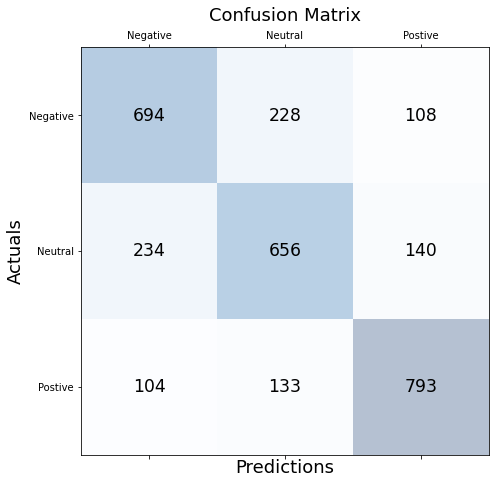

In [22]:
#Best Performace is when Minimum Document Frequency = 1

test_results, conf_matrix, y_pred = train_and_eval_model(min_df=1, ngram_range=(1,2))
labels = ['Negative','Neutral', 'Postive']

fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.title('Confusion Matrix', fontsize=18)
plt.show()